TODOs:
- think of potential KPI: does the pool get drained?
- variable: bond settings
- variable: market conditions
- variable: RBS parameters

In [1]:
from model.utility.default_parameters import default_params1 as params
from model.signals.bond_signals import total_value_bond_creation
number_runs = 10
number_steps = 100
val_ratio1=[2,1,1]
bond0 = total_value_bond_creation(start_dates= [10,30,50], simulation_timesteps=number_steps, bond_tenors=30, total_face_value=1e6,bond_value_distribution=[])
bond1 = total_value_bond_creation(start_dates= [10,30,50], simulation_timesteps=number_steps, bond_tenors=30, total_face_value=1e6,bond_value_distribution=val_ratio1)
val_ratio2 = [3,1,1]
bond2 = total_value_bond_creation(start_dates= [10,30,50], simulation_timesteps=number_steps, bond_tenors=30, total_face_value=1e6,bond_value_distribution=val_ratio2)

params.update({'bond_create_schedule':[bond0,bond1,bond2]})
params.update({'bond_schedule_name':['equal value','value ratio for diff start dates:'+str(val_ratio1),'value ratio for diff start dates:'+str(val_ratio2)]})
from model.utility.default_initial_state import default_initial_state1 as initial_state
# Fill in the initial state
from model.utility.initial_state_functions import fill_in_initial_state
initial_state = fill_in_initial_state(initial_state, params)

from model.run import load_config, run, post_processing
# Load the experiment
exp = load_config(number_runs, params, initial_state, number_steps)

# Run the experiment
raw = run(exp)

# Parse the raw data
df = post_processing(raw)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 22, 30, 68)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 22, 30, 68)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 123.12s


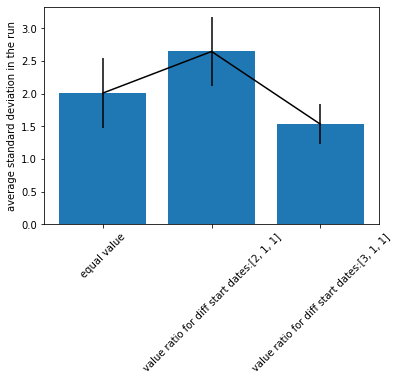

In [2]:
from model.utility.visualization import plot_price_standard_deviation

plot_price_standard_deviation(df)          


In [3]:
from model.utility.default_parameters import default_params1 as params
from model.signals.bond_signals import total_value_bond_creation
number_runs = 10
number_steps = 100
val_ratio1=[2,1,1]
bond0 = total_value_bond_creation(start_dates= 5, simulation_timesteps=number_steps, bond_tenors=[30,60,90], total_face_value=5e5,bond_value_distribution=[])
bond1 = total_value_bond_creation(start_dates= 5, simulation_timesteps=number_steps, bond_tenors=[30,60,90], total_face_value=5e5,bond_value_distribution=val_ratio1)
val_ratio2 = [3,1,1]
bond2 = total_value_bond_creation(start_dates= 5, simulation_timesteps=number_steps, bond_tenors=[30,60,90], total_face_value=5e5,bond_value_distribution=val_ratio2)

params.update({'bond_create_schedule':[bond0,bond1,bond2]})
params.update({'bond_schedule_name':['equal value','value ratio for diff tenors:'+str(val_ratio1),'value ratio for diff tenors:'+str(val_ratio2)]})
from model.utility.default_initial_state import default_initial_state1 as initial_state
# Fill in the initial state
from model.utility.initial_state_functions import fill_in_initial_state
initial_state = fill_in_initial_state(initial_state, params)

from model.run import load_config, run, post_processing
# Load the experiment
exp = load_config(number_runs, params, initial_state, number_steps)

# Run the experiment
raw = run(exp)

# Parse the raw data
df2 = post_processing(raw)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 22, 30, 68)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 22, 30, 68)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 131.63s


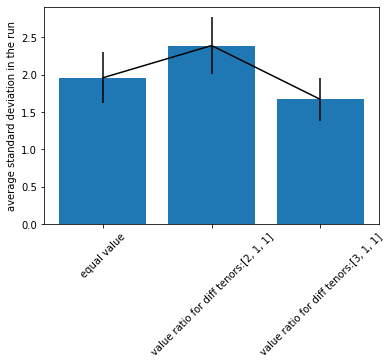

In [4]:
plot_price_standard_deviation(df2)          


From the current simulation, either the unequal distribution for bonds of different starting dates or different tenors won't cause any statistically significant 